## 12-1 시계열 탐색적 분석

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

ts = pd.read_csv('./data/12_covid19.csv', encoding= 'cp949')
ts = ts[['날짜', '전일대비증감수']]
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') # 날짜 데이터로 설정
ts = ts.set_index('날짜')
ts_head = ts.head(334)
ts_tail = ts.tail(31)
ts_head

,전일대비증감수
날짜,
2021-01-01,357
2021-01-02,250
2021-01-03,198
2021-01-04,329
2021-01-05,199
...,...
2021-11-26,1742
2021-11-27,1888
2021-11-28,1676


일반적 EDA

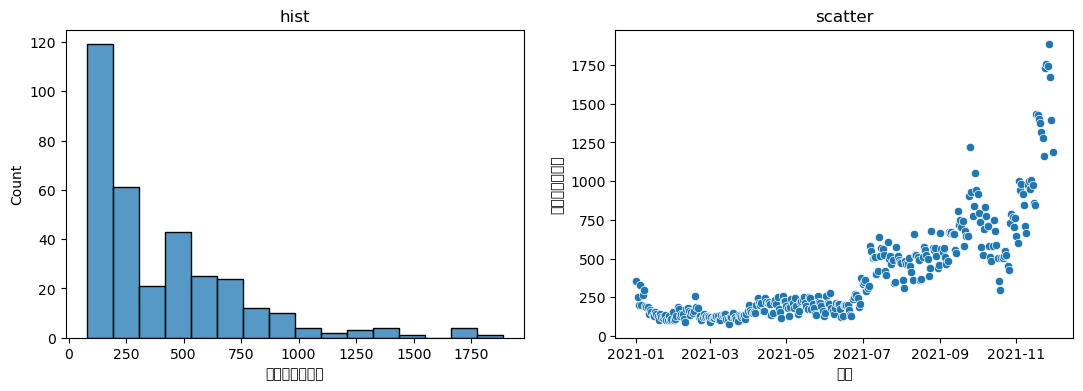

         count        mean         std   min    25%    50%    75%     max
전일대비증감수  334.0  405.152695  336.013188  79.0  152.0  252.5  556.0  1888.0


In [3]:
import seaborn as sns
import warnings
warnings.filterwarnings(action= 'ignore')

fig, axes = plt.subplots(1,2, figsize = (13,4))

axes[0].set_title('hist')
sns.histplot(x = '전일대비증감수', data = ts_head, ax = axes[0])

axes[1].set_title('scatter')
sns.scatterplot(x = '날짜', y = '전일대비증감수', data= ts_head, ax = axes[1])
plt.show()

print(ts_head.describe().T)

시계열에 특화된 EDA

> 정상성 확인

In [4]:
# 정상성 검정1 - ADF
# H0 : 단위근을 포함한다 (비정상)
# H1 : 단위근을 포함하지 않는다 (정상)

from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_head, regression= 'c', autolag='AIC')
print('ADF 검정통계량 :{}, pvalue : {}'.format(result[0], result[1]))

# ts_head 는 비정상 시계열 데이터이다.

ADF 검정통계량 :0.7623135388299553, pvalue : 0.9910028277484191


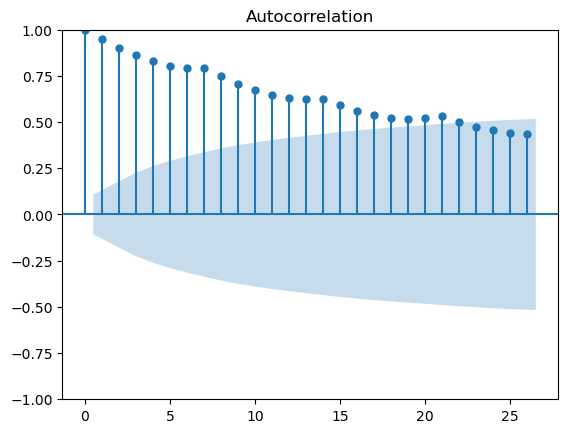

In [5]:
# 정상성 검정2 - KPSS
# 정상성 검정3 - ACF 그래프
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_head)
plt.show() # 시차에 따라 값이 빠르게 떨어지지 않기 때문에 비정상 시계열이라는 결론

> 자기상관확인(AR)

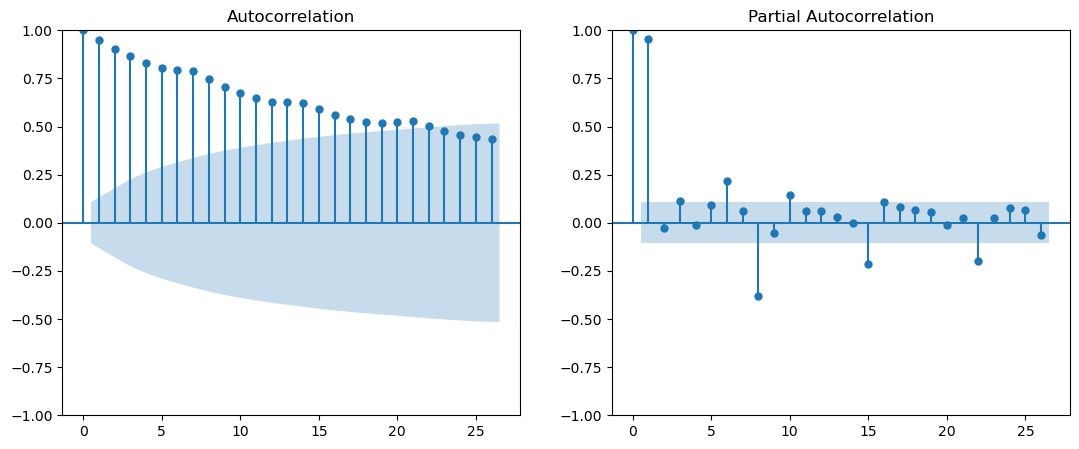

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# 자기상관 검정1 - ACF/PACF 그래프

fig, ax = plt.subplots(1,2, figsize = (13,5))
plot_acf(ts_head, ax = ax[0])
plot_pacf(ts_head, ax = ax[1])
plt.show()

# ACF 그래프의 임계영역을 벗어나는 값들을 볼 때, 자기 상관이 있음을 알 수 있다.
# PACF 그래프의 임계영역을 벗어나는 시차 1,3,6,8 등이 자기 상관이 있음

In [7]:
# 자기상관 검정2 - Ljung-box test
# H0 : 데이터가 일련의 상관관계가 없다
# H1 : 데이터가 일련의 상관관계가 있다
from statsmodels.stats.diagnostic import acorr_ljungbox
print('융박스 테스트')

result = acorr_ljungbox(ts_head, return_df = True, auto_lag= True)
print(result)

# 데이터가 상관관계가 있다는 결론

융박스 테스트
          lb_stat      lb_pvalue
1      304.691106   3.131578e-68
2      579.605498  1.381228e-126
3      833.394832  2.474556e-180
4     1067.333259  9.111938e-230
5     1286.641140  5.005454e-276
..            ...            ...
327  18675.618923   0.000000e+00
328  18688.620396   0.000000e+00
329  18698.628106   0.000000e+00
330  18704.259818   0.000000e+00
331  18708.005461   0.000000e+00

[331 rows x 2 columns]


In [31]:
# 자기상관 검정3 - Durbin-watson test
# 통계량이 2에 가까우면 자기 상관이 없다.
# 통계량이 0 또는 4에 가까우면 자기 상관이 있다.

from statsmodels.stats.stattools import durbin_watson
result = durbin_watson(ts_head)
print(result)

[0.03337102]


> 시계열 분해

+ 이동평균법 : 계절 변동과 불규칙 변동을 제거
+ 지수평활법 : 불규칙 변동 제거

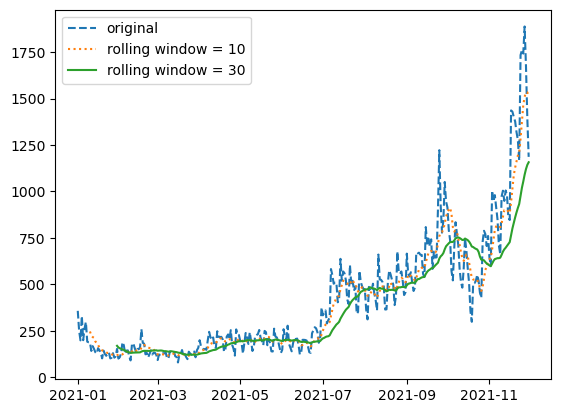

In [32]:
# 이동평균법 : 계절 변동과 불규칙 변동 제거
fig, ax = plt.subplots(1,1)

titles = ['original', 'rolling window = 10', 'rolling window = 30']
rw10 = ts_head.rolling(window = 10).mean().dropna()
rw30 = ts_head.rolling(window = 30).mean().dropna()
data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label = title, linestyle = ls)

plt.legend()
plt.show()

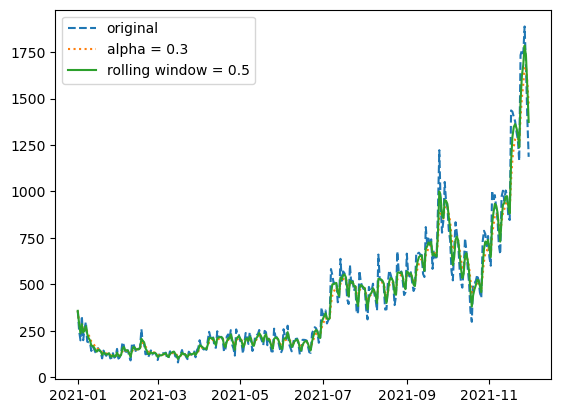

In [9]:
# 지수평활법 : 불규칙변동 제거
fig, ax = plt.subplots(1,1)

titles = ['original', 'alpha = 0.3', 'rolling window = 0.5']
ewm03 = ts_head.ewm(alpha = 0.3).mean()
ewm05 = ts_head.ewm(alpha = 0.5).mean()
 
data_list = [ts_head, ewm03, ewm05]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label = title, linestyle = ls)
    
plt.legend()
plt.show()

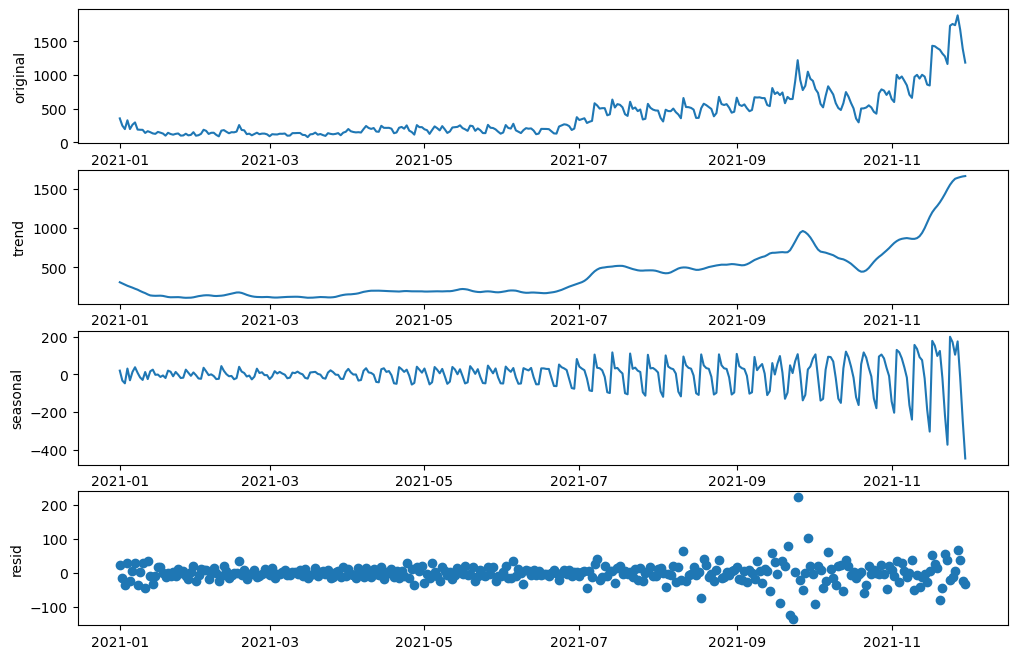

In [11]:
# STL 분해
from statsmodels.tsa.seasonal import STL
# seasonal : length of the seasonal smoother
# trend = length of the trend smoother
fitted = STL(ts_head, seasonal = 7, trend = 9).fit()
resid = fitted.resid # 잔차
seasonal = fitted.seasonal # 추정된 계절 요소
trend = fitted.trend # 추정된 트렌드 요소

titles = ['original', 'trend', 'seasonal', 'resid']
data_list = [ts_head, trend, seasonal, resid]
fig, axes = plt.subplots(4,1, figsize = (12,8))
for title, data, ax in zip(titles, data_list, axes):
    ax.set_ylabel(title)
    if title != 'resid':
        ax.plot(data)
    else:
        ax.scatter(x=data.index, y = data.values)
        
plt.show()

## 12-2 시계열 데이터 전처리

시계열 데이터 다루기
+ 날짜 데이터로 타입 변경
+ 날짜 데이터 생성
+ 날짜 데이터의 형태, 값 변경하기
+ 날짜 데이터 간 연산하기
+ 년, 월, 일, 요일 명, 요일 인덱스 추출하기

In [14]:
import datetime
import pandas as pd
import numpy as np
ts = pd.read_csv('./data/12_covid19.csv', encoding= 'cp949')
ts.head()

,날짜,누적확진자수,전일대비증감수
0,2021.1.1,19352,357
1,2021.1.2,19602,250
2,2021.1.3,19800,198
3,2021.1.4,20129,329
4,2021.1.5,20328,199


In [15]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   날짜       365 non-null    object
 1   누적확진자수   365 non-null    int64 
 2   전일대비증감수  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [18]:
# 날짜 데이터로 타입 변경하기
ts['날짜'] = ts['날짜'].astype('datetime64')
print(ts['날짜'].dtypes)

datetime64[ns]


In [24]:
# 날짜 데이터로 타입 변경하기2 - string - datetime
string = '2018-09-13 22:39:04'

# string에서 나타나는 년월일 정보와 대응하도록 format 을 적어줘야 해당 날짜로 인식 가능
date = datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
print(date, type(date))

# 원래 형태로 복원
string2 = date.strftime('%Y-%m-%d %H:%M:%S')
print(string2, type(string2))

2018-09-13 22:39:04 <class 'datetime.datetime'>
2018-09-13 22:39:04 <class 'str'>


In [28]:
# 날짜 데이터로 타입 변경하기3 - timestamp - datetime
import time

timestamp = 2551780740 # timestamp
date = datetime.datetime.fromtimestamp(timestamp)
timestamp2 = time.mktime(date.timetuple())

print('timestamp :', timestamp)
print('timestamp to datetime :', date)
print('datetime to timestamp :', timestamp2)

timestamp : 2551780740
timestamp to datetime : 2050-11-11 20:59:00
datetime to timestamp : 2551780740.0


In [29]:
# 날짜 데이터 생성하기 - datetime.datetime
date1 = datetime.datetime(2023, 3, 20, 16, 0, 0) # year, month, day, hour, minute, second
date2 = datetime.datetime.now()
date_only = datetime.date(2019, 1, 1)
time_only = datetime.time(10, 0, 5)

print('직접 만든 날짜 데이터 :', date1)
print('현재 시간을 반환하는 날짜 데이터 :', date2)
print('date only :', date_only)
print('time only :', time_only)

직접 만든 날짜 데이터 : 2023-03-20 16:00:00
현재 시간을 반환하는 날짜 데이터 : 2023-10-14 14:38:43.641210
date only : 2019-01-01
time only : 10:00:05


In [34]:
# 날짜 데이터 생성하기2 - pd.date_range, pd.period_range
date_list1 = pd.date_range('2016-01-01', periods =3, freq = 'D')
date_list2 = pd.date_range('2016-01-01', periods =4, freq = 'W')
date_list3 = pd.date_range('2016-01-01', '2016-01-02', freq = '30T') # 시간은 60T
print('일 단위 날짜들 3개', date_list1)
print('주 단위 날짜들 4개', date_list2)
print('시작-종료날짜 사이 30분 단위 날짜들', date_list3[:4])

일 단위 날짜들 3개 DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03'], dtype='datetime64[ns]', freq='D')
주 단위 날짜들 4개 DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24'], dtype='datetime64[ns]', freq='W-SUN')
시작-종료날짜 사이 30분 단위 날짜들 DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:30:00',
               '2016-01-01 01:00:00', '2016-01-01 01:30:00'],
              dtype='datetime64[ns]', freq='30T')


In [37]:
date_list4 = pd.period_range('2012-01-01', freq = 'A', periods = 2)
date_list5 = pd.period_range('2012-01-01', freq = 'Q', periods = 3)
print('년 단위 날짜들 2개 :', date_list4)
print('분기 단위 날짜들 3개 :', date_list5)

년 단위 날짜들 2개 : PeriodIndex(['2012', '2013'], dtype='period[A-DEC]')
분기 단위 날짜들 3개 : PeriodIndex(['2012Q1', '2012Q2', '2012Q3'], dtype='period[Q-DEC]')


In [41]:
# 날짜 데이터의 형태, 값 변경하기
date3 = datetime.datetime(2023, 3, 20, 0, 1, 10)
date3_c1 = date3.strftime('%Y-%m-%d')
date3_c2 = date3.strftime('%y년 %m-%d %H:%m')
print(date3)
print(date3_c1)
print(date3_c2)

2023-03-20 00:01:10
2023-03-20
23년 03-20 00:03


In [42]:
date4 = date3.replace(year = 2022, minute = 2)
print(date4)

2022-03-20 00:02:10


In [44]:
date_only = datetime.date(2019 ,1, 1)
time_only = datetime.time(10, 0, 5)
date = datetime.datetime.combine(date_only, time_only)
print(date_only)
print(time_only)
print(date) # 병합

2019-01-01
10:00:05
2019-01-01 10:00:05


In [45]:
# 날짜 데이터 간 연산하기
weeks1 = datetime.timedelta(weeks = 1)
today = datetime.date(2023, 2, 10)
print(today)
print(today - weeks1)
print(today + weeks1)

2023-02-10
2023-02-03
2023-02-17


In [49]:
# 년, 월, 일, 요일명, 요일인덱스 추출하기
import datetime as dt

ts.날짜 = ts.날짜.astype('datetime64')
ts['년'] = ts.날짜.dt.year
ts['월'] = ts.날짜.dt.month
ts['일'] = ts.날짜.dt.day
ts['요일1'] = ts.날짜.dt.weekday
ts['요일2'] = ts.날짜.dt.day_name()

ts.head()

,날짜,누적확진자수,전일대비증감수,년,월,일,요일1,요일2
0,2021-01-01,19352,357,2021,1,1,4,Friday
1,2021-01-02,19602,250,2021,1,2,5,Saturday
2,2021-01-03,19800,198,2021,1,3,6,Sunday
3,2021-01-04,20129,329,2021,1,4,0,Monday
4,2021-01-05,20328,199,2021,1,5,1,Tuesday


시계열 빈도 변경(업샘플링, 다운샘플링)

In [52]:
ts = pd.read_csv('./data/12_covid19.csv', encoding = 'cp949')
ts.날짜 = ts.날짜.astype('datetime64')
ts.set_index('날짜', inplace = True)
ts.head()

,누적확진자수,전일대비증감수
날짜,,
2021-01-01,19352,357
2021-01-02,19602,250
2021-01-03,19800,198
2021-01-04,20129,329
2021-01-05,20328,199


In [54]:
# rule = A, M, D, T, S, Q, W (년, 월, 일, 분, 초, 분기, 주)
# aggregating = .asfreq(), sum(), mean()
print(ts.resample(rule = "Q").asfreq())

            누적확진자수  전일대비증감수
날짜                         
2021-03-31   32029      158
2021-06-30   49986      375
2021-09-30  100492      945
2021-12-31  225235     1670


결측치 처리

In [59]:
ts = pd.read_csv('./data/12_covid19.csv', encoding = 'cp949')
ts['날짜'] = ts['날짜'].astype('datetime64')
ts = ts[['날짜', '전일대비증감수']]
ts.set_index('날짜', inplace = True)
ts.head()

,전일대비증감수
날짜,
2021-01-01,357
2021-01-02,250
2021-01-03,198
2021-01-04,329
2021-01-05,199


In [63]:
# 결측치 있는 데이터로 만들기
ts_na = ts.copy()
import numpy as np
random_numbers = np.random.randint(0, len(ts)-1, 50)
for num in random_numbers:
    ts_na.iloc[num, :] = np.nan
    
ts_na.isnull().sum()

전일대비증감수    46
dtype: int64

<Axes: xlabel='title'>

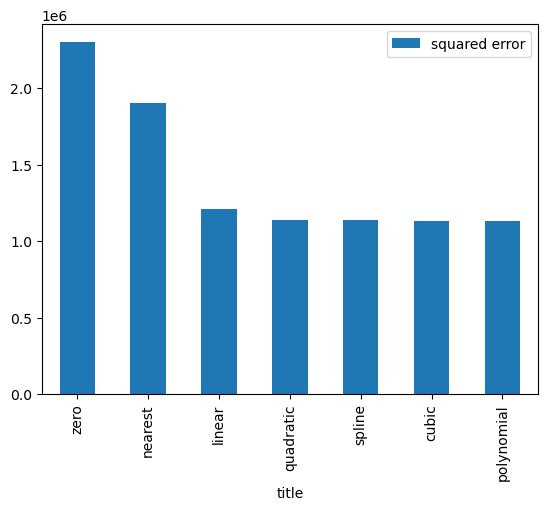

In [72]:
# 각종 보간 후, 실제 데이터와의 비교
linear = ts_na.interpolate(method = 'linear')
nearest = ts_na.interpolate(method = 'nearest')
zero = ts_na.interpolate(method = 'zero')
quadratic = ts_na.interpolate(method = 'quadratic')
cubic = ts_na.interpolate(method = 'cubic')
spline = ts_na.interpolate(method = 'spline', order = 2)
polynomial = ts_na.interpolate(method = 'polynomial', order = 3)

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic' , 'spline', 'polynomial']
data_list = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
sqrd_error = []
for title, data in zip(titles, data_list):
    sqrd_e = sum((ts - data)['전일대비증감수'] ** 2)
    sqrd_error.append(int(sqrd_e))
    
result = pd.DataFrame({'title' : titles, 'error' : sqrd_error}).sort_values(by = 'error', ascending = False)

result.plot.bar(x = 'title', y = 'error', label = 'squared error')

<Axes: xlabel='title'>

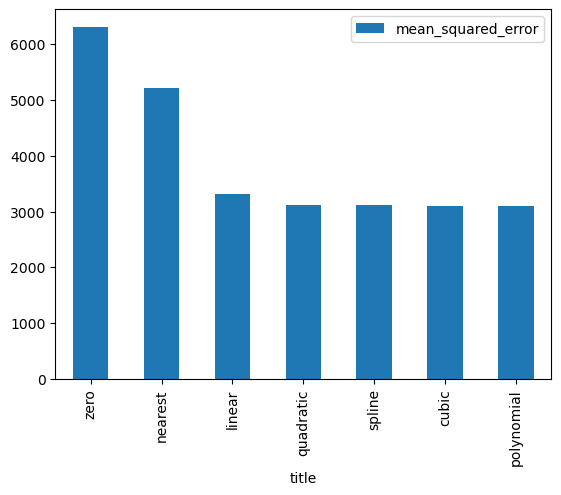

In [76]:
# 각종 보간 후, 실제 데이터와의 비교
linear = ts_na.interpolate(method = 'linear')
nearest = ts_na.interpolate(method = 'nearest')
zero = ts_na.interpolate(method = 'zero')
quadratic = ts_na.interpolate(method = 'quadratic')
cubic = ts_na.interpolate(method = 'cubic')
spline = ts_na.interpolate(method = 'spline', order = 2)
polynomial = ts_na.interpolate(method = 'polynomial', order = 3)

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic' , 'spline', 'polynomial']
data_list = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
from sklearn.metrics import mean_squared_error

total_mse = []
for title, data in zip(titles, data_list):
    mse = mean_squared_error(ts['전일대비증감수'], data['전일대비증감수'])
    total_mse.append(mse)
    
result = pd.DataFrame({'title' : titles, 'mse' : total_mse}).sort_values(by = 'mse', ascending = False)

result.plot.bar(x = 'title', y = 'mse', label = 'mean_squared_error')

차분과 변환

In [77]:
ts = pd.read_csv('./data/12_covid19.csv', encoding = 'cp949')
ts['날짜'] = ts['날짜'].astype('datetime64')
ts = ts[['날짜', '전일대비증감수']]
ts.set_index('날짜', inplace = True)
ts_head = ts.head(334)
ts_tail = ts.tail(31)

original : ADF-pvale 0.9910028277484191, KPSS pvalue 0.01
diff(1) : ADF-pvale 0.0036253512255103844, KPSS pvalue 0.1
diff(2) : ADF-pvale 0.004660529794714033, KPSS pvalue 0.1


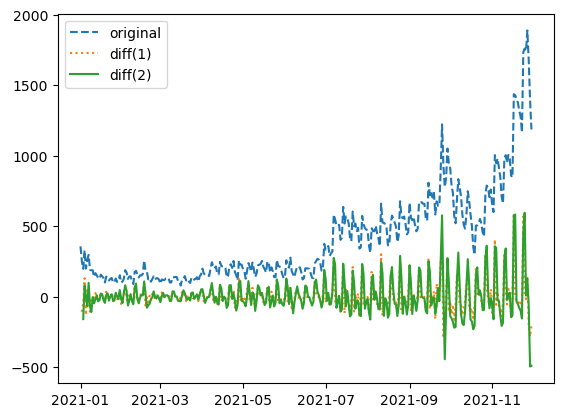

In [81]:
# 차분 전후 비교
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.stattools import adfuller, kpss
fig, ax = plt.subplots(1,1)

titles = ['original', 'diff(1)', 'diff(2)']
diff1 = ts_head.diff(periods = 1).dropna()
diff2 = ts_head.diff(periods = 2).dropna()
data_list = [ts_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label = title, linestyle = ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    
    print('{} : ADF-pvale {}, KPSS pvalue {}'.format(title, ap, kp))
    
plt.legend()
plt.show()

# 1번의 차분으로 정상시계열이 되었다.

original : ADF-pvale 0.9910028277484191, KPSS pvalue 0.01
log : ADF-pvale 0.0007331780357098981, KPSS pvalue 0.1
boxcox : ADF-pvale 0.0003760395058520414, KPSS pvalue 0.1


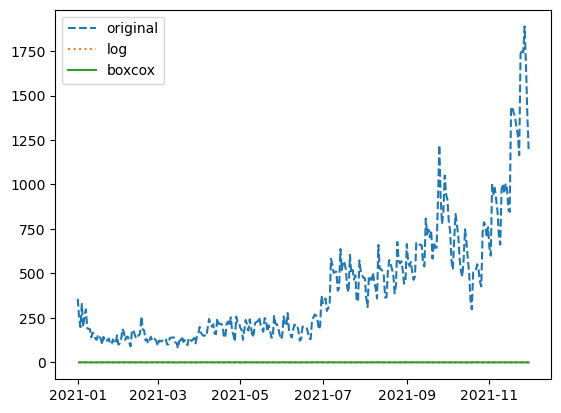

In [82]:
# 변환과 차분 전후 바교
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer
import numpy as np

# 로그변환
log = np.log1p(ts_head)

# 박스콕스 변환
pt = PowerTransformer(method = 'box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index = ts_head.index, columns = ts_head.columns)

# 차분 1회
log = log.diff(1).dropna()
boxcox = boxcox.diff(1).dropna()

# 시각화
fig, ax = plt.subplots(1,1)

titles = ['original', 'log', 'boxcox']
data_list = [ts_head, log, boxcox]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label = title, linestyle = ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    
    print('{} : ADF-pvale {}, KPSS pvalue {}'.format(title, ap, kp))
    
plt.legend()
plt.show()

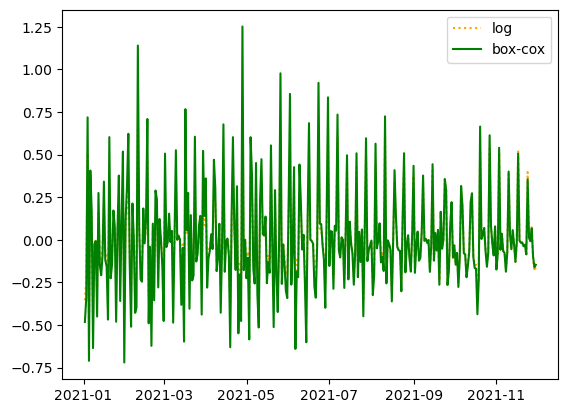

In [85]:
fig, ax = plt.subplots(1,1)
titles, data_list = ['log', 'box-cox'], [log, boxcox]
ls_list, c_list = ['dotted', 'solid'], ['orange' ,'green']

for title, data, ls, c in zip(titles, data_list, ls_list, c_list):
    ax.plot(data, label = title, linestyle = ls, color = c)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    
plt.legend()
plt.show()

## 12-3 시계열 모델링 및 평가

박스-젠킨스 방법과 ARIMA

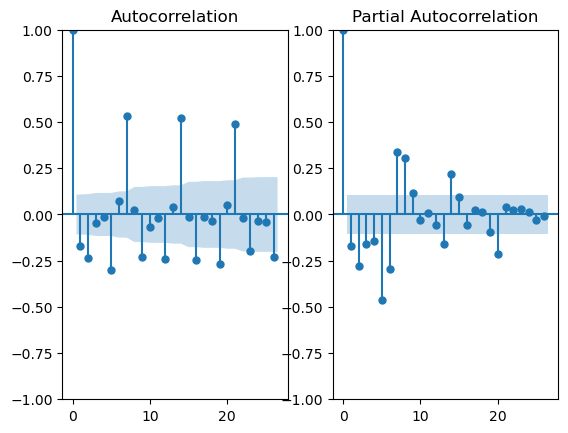

In [89]:
# 박스 -젠킨스 방법
## boxcox 변환 및 차분을 통해 정상화한 시계열 데이터 'boxcox' 로 적절한 차수를 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2)
plot_acf(boxcox, ax = ax[0])
plot_pacf(boxcox, ax = ax[1])
plt.show()
# 차수는 plot 상의 절단점을 참고하여 p = 9, q = 2 로 정하고 모델을 적합, 계절성은 있는 것으로 보인다

# 모델의 비계절성 부분
p = 9 # AR 차수
d = 1 # 차분 횟수
q = 2 # MA 차수

# 모델의 계절성 부분 (계절성이 없으면 생략가능)
P = 0
D = 0 
Q = 1 # ACF lag7에서 뾰족한 막대를 가지고, PACF 는 지수적으로 감수
s = 7 # ACF lag7에서 뾰족한 막대를 가짐, 계절성 단위 (seasonal period)

In [92]:
## 모델 예측 및 잔차 분석
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# ARIMA 에서 seasonal_order 입력하면 SARIMAX 와 같은 결과를 얻음
model = ARIMA(ts_head, order = (p,d,q), seasonal_order = (P,D,Q,s)) # 원본 데이터 입력
fitted = model.fit()
resid = fitted.resid

# pred1, pred2 는 동일한 값임
pred1 = fitted.forecast(31)
pred2 = fitted.predict(start = ts_tail.index[0], end = ts_tail.index[-1]) # 시작/종료날짜로 예측

# 잔차의 정규성 확인 : Jarque-Bera 검정을 통해 귀무가설을 채택하면 정규성을 가짐
# 잔차의 자기상관 확인 : Ljung-Box 검정을 통해 귀무가설을 채택하면 , 자기상관이 없다

fitted.summary()
# ACF/PACF plot 관찰을 통해 SARIMA 모델을 적합하였으나 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선이 필요하다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.018
Date:                           Sat, 14 Oct 2023   AIC                           3734.036
Time:                                   16:44:27   BIC                           3783.542
Sample:                               01-01-2021   HQIC                          3753.777
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0276      1.000     -0.028      0.978      -1.988       1.933
ar.L2         -0.1713      0.495     -0.346      0.730      -1.142       0.800
ar.L3         -0.0263      0.029     -0.916      0.360      -0.083       0.030
ar.L4         -0.0399      0.038     -1.063      0.288      -0.114       0.034
ar.L5         -0.0378      0.033     -1.150      0.250      -0.102       0.027
ar.L6         -0.0318      0.031     -1.025      0.305      -0.093       0.029
ar.L7          0.9458      0.040     23.503      0.000       0.867       1.025
ar.L8          0.0039      0.973      0.004      0.997      -1.903       1.910
ar.L9          0.1365      0.475      0.287      0.774      -0.794       1.067
ma.L1         -0.2076      0.993     -0.209      0.834      -2.155       1.740
ma.L2          0.0481      0.705      0.068      0.946      -1.334       1.430
ma.S.L7       -0.6530      0.059    -11.158      0.000      -0.768      -0.538
sigma2      4657.2804    268.257     17.361      0.000    4131.507    5183.054
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1188.10
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.50   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

자동 차수 선택 방법과 ARIMA

In [ ]:
!pip install pmdarima

In [97]:
# 자동 차수 선택1 - pmdarima 의 auto_arima
from pmdarima import auto_arima
auto_arima(ts_head, start_p = 1, start_q =1, max_p = 5, max_q = 5, 
           start_P = 0, start_Q = 0, max_P = 5, max_Q = 5, m =7,
           seasonal = True, trace = False, error_action = 'warn', suppress_warnings = True)

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [98]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_head, order = (3,1,0), seasonal_order = (1,0,1,7))
fitted = model.fit()

resid = fitted.resid
pred3 = fitted.forecast(31)
pred4 = fitted.predict(start = ts_tail.index[0], end = ts_tail.index[-1])
# 잔차의 정규성 확인 : Jarque-Bera 검정을 통해 귀무가설을 채택하면, 정규성을 갖는다.
# 잔차의 자기상관 확인 : Ljung-Box 검정을 통해 귀무가설을 채택하면, 자기상관은 없다.

fitted.summary() # 잔차가 정규성을 만족하지 않기 때문에 추가적이 모델 개선이 필요하다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Sat, 14 Oct 2023   AIC                           3717.507
Time:                                   17:13:48   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2260      0.036     -6.293      0.000      -0.296      -0.156
ar.L2         -0.1731      0.039     -4.396      0.000      -0.250      -0.096
ar.L3         -0.1134      0.042     -2.691      0.007      -0.196      -0.031
ar.S.L7        0.9825      0.015     66.323      0.000       0.953       1.012
ma.S.L7       -0.6567      0.040    -16.420      0.000      -0.735      -0.578
sigma2      3830.1225    168.177     22.774      0.000    3500.503    4159.742
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               918.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
# 예측 성능 비교
from sklearn.metrics import r2_score, mean_squared_error

titles = ['box-jenkins', 'auto_arima']
ts_tailed = ts_tail.values.ravel()
preds = [pred1.values, pred3.values]
for title, pred in zip(titles, preds):
    r2 = r2_score(ts_tailed, pred)
    mse = mean_squared_error(ts_tailed, pred)
    
    print('{} : R2 {}, MSE {}'.format(title, r2, mse))

box-jenkins : R2 -1.5182587213870748, MSE 611169.6572763202
auto_arima : R2 -0.7396619367666672, MSE 422207.845699313


In [101]:
ts_tail.values.ravel()

array([2222, 2268, 2099, 2273, 2032, 1408, 2120, 2901, 2790, 2800, 2835,
       2528, 2550, 2062, 3166, 3057, 2846, 2794, 2320, 1908, 1994, 2805,
       2720, 2346, 2123, 1917, 1496, 1290, 1915, 1722, 1670], dtype=int64)